# Some preprocessing to implement tanh in generator

In [ ]:
from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
drive.mount('/content/gdrive')
!ls
%cd gdrive/My\ Drive/GANs_for_Tabular_data-master/cWGAN_GP/
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
 cWGAN_GP.ipynb		     cWGAN_GP-parkinson.ipynb  'Parkinsson disease.csv'
 cWGAN_GP-lung2.ipynb	    'lung cancer2.csv'	       'survey lung cancer.csv'
 cWGAN_GP-lung.ipynb	    'lung cancer-name.csv'      train.csv
 cWGAN_GP-pancreatic.ipynb  'pancreatic2020 data.csv'
[Errno 2] No such file or directory: 'gdrive/My Drive/GANs_for_Tabular_data-master/cWGAN_GP/'
/content/gdrive/My Drive/GANs_for_Tabular_data-master/cWGAN_GP
 cWGAN_GP.ipynb		     cWGAN_GP-parkinson.ipynb  'Parkinsson disease.csv'
 cWGAN_GP-lung2.ipynb	    'lung cancer2.csv'	       'survey lung cancer.csv'
 cWGAN_GP-lung.ipynb	    'lung cancer-name.csv'      train.csv
 cWGAN_GP-pancreatic.ipynb  'pancreatic2020 data.csv'


In [ ]:
import pandas as pd
import numpy as np
# normalized_df=(df-df.mean())/df.std()
df = pd.read_csv('pancreatic2020 data.csv')
df.info()
print(df.head())
df.value_counts(df['diagnosis'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sample_id                590 non-null    object 
 1   patient_cohort           590 non-null    object 
 2   sample_origin            590 non-null    object 
 3   age                      590 non-null    int64  
 4   sex                      590 non-null    object 
 5   diagnosis                590 non-null    int64  
 6   stage                    199 non-null    object 
 7   benign_sample_diagnosis  208 non-null    object 
 8   plasma_CA19_9            350 non-null    float64
 9   creatinine               590 non-null    float64
 10  LYVE1                    590 non-null    float64
 11  REG1B                    590 non-null    float64
 12  TFF1                     590 non-null    float64
 13  REG1A                    306 non-null    float64
dtypes: float64(6), int64(2), o

diagnosis
2    208
3    199
1    183
dtype: int64

In [ ]:
df.isna().sum()
feature_na=[feature for feature in df.columns if df[feature].isnull().sum()>0]
feature_na
#% of missing values
for feature in feature_na:
    print('{} has {} % missing values'.format(feature,np.round(df[feature].isnull().sum()/len(df)*100,4)))

stage has 66.2712 % missing values
benign_sample_diagnosis has 64.7458 % missing values
plasma_CA19_9 has 40.678 % missing values
REG1A has 48.1356 % missing values


In [ ]:
del(df['stage'])
del(df['benign_sample_diagnosis'])
del(df['sample_id'])
df['plasma_CA19_9'].fillna(int(df['plasma_CA19_9'].mean()), inplace=True)
df['REG1A'].fillna(int(df['REG1A'].mean()), inplace=True)
df.isna().sum()

patient_cohort    0
sample_origin     0
age               0
sex               0
diagnosis         0
plasma_CA19_9     0
creatinine        0
LYVE1             0
REG1B             0
TFF1              0
REG1A             0
dtype: int64

In [ ]:
feature_na=[feature for feature in df.columns if df[feature].isnull().sum()>0]
feature_na

[]

In [ ]:
#len(df['diagnosis'].unique())
df['diagnosis'] = df['diagnosis'].map({1: 0, 2: 0, 3:1})
df['diagnosis'] = pd.to_numeric(df['diagnosis'], errors='coerce')
len(df['diagnosis'].unique())
df.head()
df['diagnosis'].value_counts()

0    391
1    199
Name: diagnosis, dtype: int64

In [ ]:
df['age'].unique()
df['sex'].unique()
df['sex'].value_counts()
df['sex'] = df['sex'].map({'M': 1, 'F': 0})
df['sex'] = pd.to_numeric(df['sex'], errors='coerce')
df['sex'].value_counts()

0    299
1    291
Name: sex, dtype: int64

In [ ]:
df['patient_cohort'] = df['patient_cohort'].map({'Cohort1': 1, 'Cohort2': 0})
df['patient_cohort'] = pd.to_numeric(df['patient_cohort'], errors='coerce')
df['patient_cohort'].value_counts()


1    332
0    258
Name: patient_cohort, dtype: int64

In [ ]:
df['sample_origin'] = df['sample_origin'].map({'BPTB': 0, 'LIV': 1,'ESP': 2,'UCL': 3})
df['sample_origin'] = pd.to_numeric(df['sample_origin'], errors='coerce')
df["sample_origin"].value_counts()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   patient_cohort  590 non-null    int64  
 1   sample_origin   590 non-null    int64  
 2   age             590 non-null    int64  
 3   sex             590 non-null    int64  
 4   diagnosis       590 non-null    int64  
 5   plasma_CA19_9   590 non-null    float64
 6   creatinine      590 non-null    float64
 7   LYVE1           590 non-null    float64
 8   REG1B           590 non-null    float64
 9   TFF1            590 non-null    float64
 10  REG1A           590 non-null    float64
dtypes: float64(6), int64(5)
memory usage: 50.8 KB


# Importing the dependencies

In [ ]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            plot_confusion_matrix, confusion_matrix

# Creating pytorch dataset and dataloader

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

Data preprocess

In [ ]:
#df = pd.read_csv('lung cancer-name.csv')
#df.info()

#x = df.iloc[:, 0:7].values
#y = df.iloc[:, -1].values
#target='diagnosis'
y = df['diagnosis']
x = df.drop(["diagnosis"], axis=1)

x.info()

#y= df["status"]
#x = df.drop(["status"], axis=1)
print(x.head())
print(y.head())

mc = MinMaxScaler(feature_range=(0, 1))
standard_scaler = mc.fit(x)
x_scaled = standard_scaler.transform(x)
x_scaled = pd.DataFrame(x_scaled)

print(x_scaled.head())
print(f"y value_count:\n {y.value_counts()}")
#x_scaled = x_scaled.values
#y = y.values

X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.20, shuffle=True)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Number of classes {len(np.unique(y_train))}")




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   patient_cohort  590 non-null    int64  
 1   sample_origin   590 non-null    int64  
 2   age             590 non-null    int64  
 3   sex             590 non-null    int64  
 4   plasma_CA19_9   590 non-null    float64
 5   creatinine      590 non-null    float64
 6   LYVE1           590 non-null    float64
 7   REG1B           590 non-null    float64
 8   TFF1            590 non-null    float64
 9   REG1A           590 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 46.2 KB
   patient_cohort  sample_origin  age  sex  plasma_CA19_9  creatinine  \
0               1              0   33    0           11.7     1.83222   
1               1              0   81    0          654.0     0.97266   
2               0              0   51    1            7.0     0.78039   
3           

              precision    recall  f1-score   support

           0       0.93      0.96      0.94        77
           1       0.92      0.85      0.89        41

    accuracy                           0.92       118
   macro avg       0.92      0.91      0.91       118
weighted avg       0.92      0.92      0.92       118



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


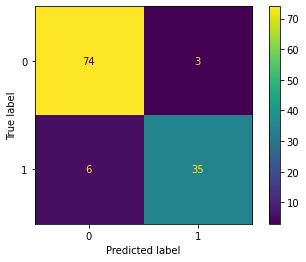

In [ ]:
#leon
import xgboost as xgb
xgb = xgb.XGBClassifier()
xgb.fit(X_train,y_train)

y_pred = xgb.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(xgb, X_test, y_test)
plt.show()

              precision    recall  f1-score   support

           0       0.90      0.96      0.93        77
           1       0.92      0.80      0.86        41

    accuracy                           0.91       118
   macro avg       0.91      0.88      0.89       118
weighted avg       0.91      0.91      0.91       118



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


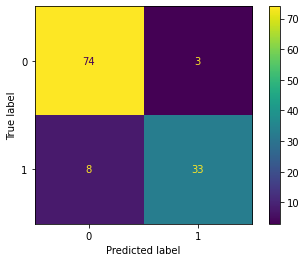

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=300, n_jobs=-1)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(rf, X_test, y_test)
plt.show()

In [ ]:
class MyDataset(Dataset):
 
  def __init__(self ,x, y):
    """
    df = pd.read_csv('train.csv')
    df["label"] = df.Survived
#     df = df[df['label'] == 1].reset_index(drop = True)
    df = df.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)
    median_age = df.Age.median()
    mode_embarked = df.Embarked.mode()[0]
    df = df.fillna({"Age": median_age, "Embarked": mode_embarked})
    df.Sex = df.Sex.replace({'male':0,'female':1})
    df.Embarked = df.Embarked.replace({'S':0,'C':1,'Q':2})
    """
    
    
    """
    mc = MinMaxScaler(feature_range=(0, 1))
    standard_scaler = mc.fit(x)
    x_scaled = standard_scaler.transform(x)

    x_scaled = pd.DataFrame(x_scaled)
    print(x_scaled.head())
    print(f"y value_count:\n {y.value_counts()}")
    x_scaled = x_scaled.values
    y = y.values
    """
    x = x.values
    y = y.values

    #X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.20, shuffle=True)
    
    #x = x.values
    #y = y.values
    #X_train = X_train.values
    #y_train = y_train.values
    #self.x_train=torch.tensor(x_scaled,dtype=torch.float32)
    self.x_train=torch.tensor(x,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.int)

    print(self.x_train[0:5])
    print(self.y_train[0:5])

  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

train_ds = MyDataset(X_train, y_train)

tensor([[1.0000e+00, 0.0000e+00, 4.7619e-02, 1.0000e+00, 1.5106e-02, 6.7688e-01,
         2.1503e-01, 6.5442e-01, 1.6543e-01, 1.4592e-01],
        [1.0000e+00, 3.3333e-01, 7.6190e-01, 0.0000e+00, 1.7871e-02, 1.2256e-01,
         1.0839e-01, 6.2962e-02, 1.6792e-02, 1.9240e-02],
        [0.0000e+00, 0.0000e+00, 4.1270e-01, 0.0000e+00, 2.1097e-02, 1.7827e-01,
         4.5060e-02, 4.1284e-03, 1.3598e-02, 5.5682e-02],
        [0.0000e+00, 0.0000e+00, 6.6667e-01, 1.0000e+00, 2.5806e-04, 2.0891e-01,
         4.2128e-02, 7.9328e-03, 4.8921e-06, 5.5682e-02],
        [1.0000e+00, 1.0000e+00, 8.5714e-01, 1.0000e+00, 2.1097e-02, 1.3649e-01,
         2.8039e-01, 5.2851e-03, 4.5989e-03, 8.0064e-03]])
tensor([1, 1, 0, 0, 0], dtype=torch.int32)


In [ ]:
#train_ds.info()

In [ ]:
batch_size = 64


train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
train_dl.device

device(type='cpu')

# Creating generator and discriminator models

<b> Generator Architecture

In [ ]:
latent_size = 10 # origin is 7 equal to columns
n_features = 10  # equal to columns
num_classes = 2
embed_size = 2  # classes number?

In [ ]:
class Generator(nn.Module):
    def __init__(self, embed_size = 2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_features + embed_size, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            #nn.Linear(32, 7),
            nn.Linear(32, 10)   # the last number is equal to columns
            
#             nn.Linear(latent_size, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(512, 256),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(256, 128),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(128, 64),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(64, 32),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(32, 16),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(16, 7),
        )
        self.embed = nn.Embedding(num_classes, embed_size)

    def forward(self, x, labels):
        embed = self.embed(labels)#.reshape(labels.shape[0], 1)
        x = torch.cat([x, embed], dim = 1)
        output = self.model(x)
        return output
    

generator = to_device(Generator(), device)

<b> Discriminator Architecture

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, embed_size = 2):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(n_features + embed_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
#             nn.Linear(n_features, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(512, 256),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(256, 128),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(128, 64),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(64, 32),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(32, 16),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(16, 1),
#             nn.Sigmoid()
        )
        
        self.embed = nn.Embedding(num_classes, embed_size)

    def forward(self, x, labels):
        embed = self.embed(labels) #.reshape(labels.shape[0], 1)
        x = torch.cat([x, embed], dim = 1)
        output = self.model(x)
        return output
    
discriminator = to_device(Discriminator(), device)

In [ ]:
# for arr, labels in train_dl:
#     break
# # nn.Embedding(2, 2).to('cuda')(labels)#.reshape(labels.shape[0], 1)

# Generator and discriminator training methodology

In [ ]:
CRITIC_ITERATIONS = 5
# WEIGHT_CLIP = 0.01
LAMBDA_GP = 10

In [ ]:
def gradient_penalty(real_data, generated_data, real_labels,device = device):
    BATCH_SIZE, features_count = real_data.shape
    epsilon = torch.rand((BATCH_SIZE, features_count)).to(device)
    epsilon = epsilon.to(device)

    interpolated_data = real_data * epsilon + generated_data * (1 - epsilon)


    # lets calculate critics score
    mixed_scores = discriminator(interpolated_data, real_labels)

    # Computes and returns the sum of gradients of outputs with respect to the inputs.
    # https://pytorch.org/docs/stable/generated/torch.ones_like.html
    # l2 norm : https://www.analyticsvidhya.com/blog/2021/03/must-known-vector-norms-in-machine-learning/
    gradient = torch.autograd.grad(
      inputs = interpolated_data,
      outputs = mixed_scores,
      grad_outputs = torch.ones_like(mixed_scores)
    )[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim = 1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [ ]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(real_data, opt_d, cur_batch_size, real_labels):
    # Reset gradients
    opt_d.zero_grad()
    
    real_labels = real_labels.to(device)
    real_preds = discriminator(real_data, real_labels).reshape(-1)

    # random noise from uniform distribution
    latent_space_samples = torch.randn((cur_batch_size, latent_size),  device = device)
    
    generated_data = generator(latent_space_samples, real_labels)  # fake data generated by generator
    fake_preds = discriminator(generated_data, real_labels).reshape(-1)
    
    # calculating gradient penalty
    gp = gradient_penalty(real_data, generated_data, real_labels,device = device)
    
    loss = -(torch.mean(real_preds) - torch.mean(fake_preds)) + LAMBDA_GP * gp

    # Compute gradients
    loss.backward()
    # Adjust the parameters using backprop
    opt_d.step()
        
    return loss

In [ ]:
def train_generator(opt_g, cur_batch_size, real_labels):
    # Clear generator gradients
    opt_g.zero_grad()
     
    # random noise from uniform distribution
    latent_space_samples = torch.randn((cur_batch_size, latent_size),  device = device)
    generated_data = generator(latent_space_samples, real_labels)  # fake data generated by generator
    fake_preds = discriminator(generated_data, real_labels.to(device)).reshape(-1)
    g_loss = -torch.mean(fake_preds)

    g_loss.backward()
    opt_g.step()
    return g_loss

# Training Loop

In [ ]:
lr = 0.001
epochs = 1000

In [ ]:
opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas = (0.5, 0.9))
opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas = (0.5, 0.9))

In [ ]:
def fit(epochs, lr, opt_d, opt_g):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []

    
    # Create optimizers
#     opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
#     opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    total_step = len(train_dl)
    for epoch in range(epochs):
        for i, (real_data, real_labels) in enumerate(train_dl):
            cur_batch_size = real_data.shape[0]
            
            for _ in range(CRITIC_ITERATIONS):            
                # Train the discriminator and generator
                d_loss = train_discriminator(real_data, opt_d, cur_batch_size, real_labels)            
                
            g_loss = train_generator(opt_g, cur_batch_size, real_labels)
            
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'
                  .format(epoch, epochs, i+1, total_step, d_loss.item(), g_loss.item()))
        # Loss of last batch
        losses_d.append(d_loss.item())
        losses_g.append(g_loss.item())
    return losses_g, losses_d

In [ ]:
%%time

history = fit(epochs, lr, opt_d, opt_g)

流式输出内容被截断，只能显示最后 5000 行内容。
Epoch [375/1000], Step [3/8], d_loss: 9.2500, g_loss: -0.0000
Epoch [375/1000], Step [4/8], d_loss: 12452.1328, g_loss: -0.0000
Epoch [375/1000], Step [5/8], d_loss: 9.2086, g_loss: -0.0000
Epoch [375/1000], Step [6/8], d_loss: 10.8075, g_loss: -0.0000
Epoch [375/1000], Step [7/8], d_loss: 3074.1182, g_loss: -0.0000
Epoch [375/1000], Step [8/8], d_loss: 9.2083, g_loss: -0.0000
Epoch [376/1000], Step [1/8], d_loss: 53.9608, g_loss: -0.0000
Epoch [376/1000], Step [2/8], d_loss: 9.2485, g_loss: -0.0156
Epoch [376/1000], Step [3/8], d_loss: 9.2586, g_loss: -0.0156
Epoch [376/1000], Step [4/8], d_loss: 180.4325, g_loss: -0.0000
Epoch [376/1000], Step [5/8], d_loss: 9.0391, g_loss: -0.0000
Epoch [376/1000], Step [6/8], d_loss: 9.1863, g_loss: -0.0156
Epoch [376/1000], Step [7/8], d_loss: 1389.2806, g_loss: -0.0000
Epoch [376/1000], Step [8/8], d_loss: 9.2080, g_loss: -0.0000
Epoch [377/1000], Step [1/8], d_loss: 9.9272, g_loss: -0.0000
Epoch [377/1000], Step [2/8],

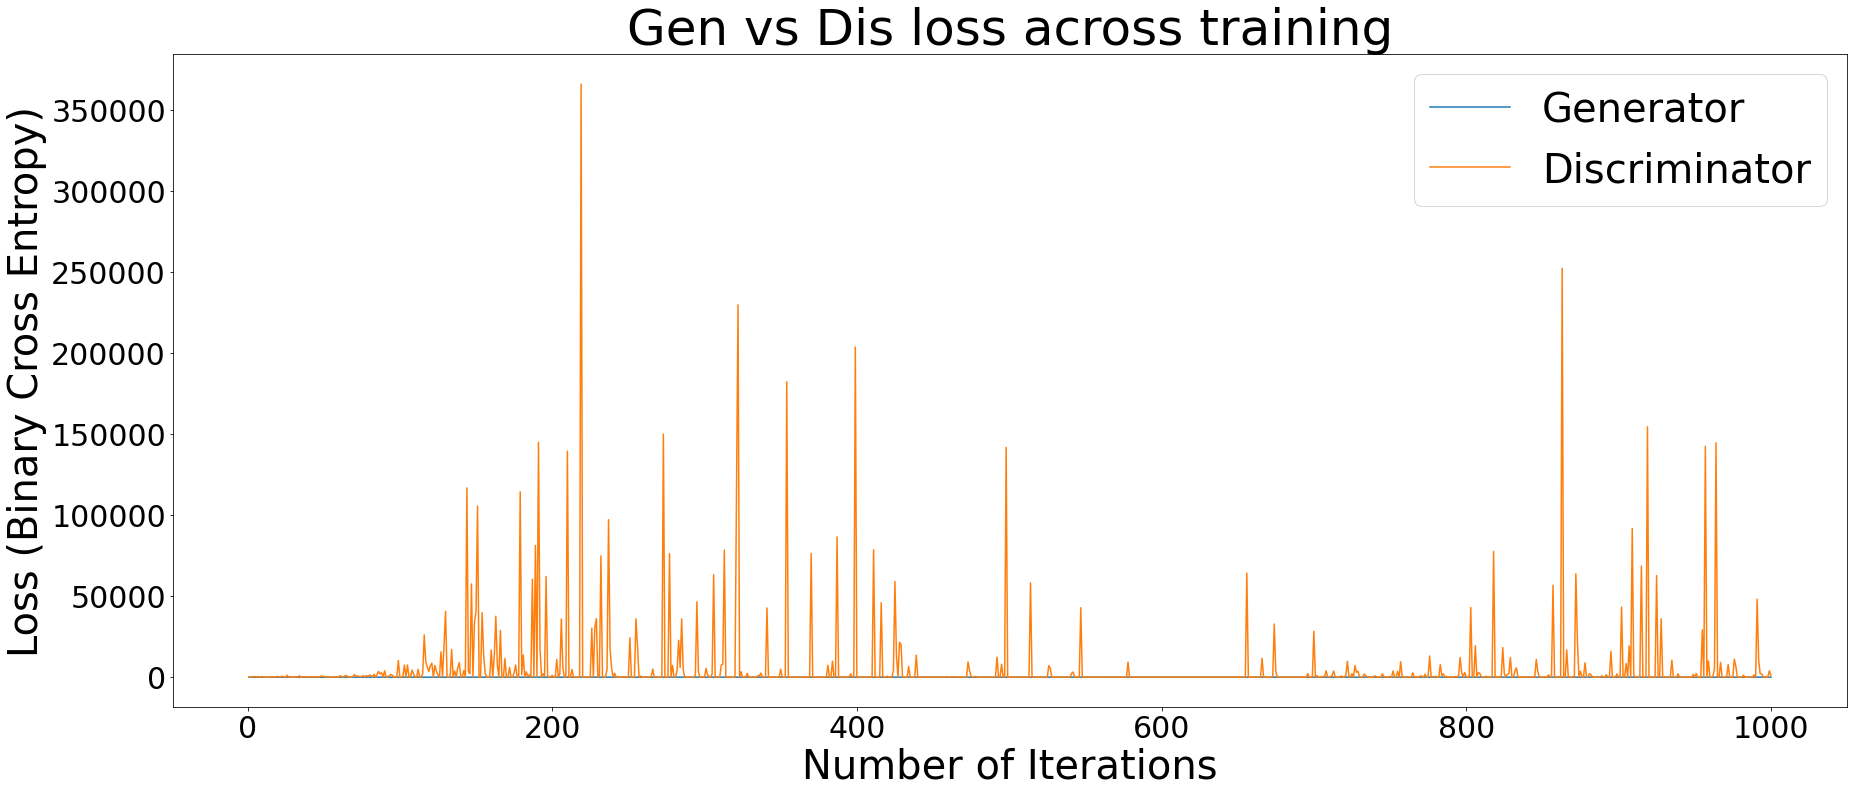

In [ ]:
losses_g, losses_d = history[0], history[1]

fig, axes = plt.subplots(1,1, figsize=(30, 12))
ax1 = plt.subplot(1,1,1)

plt.plot(range(1,1001), losses_g, label = 'Generator')
plt.plot(range(1, 1001), losses_d, label = 'Discriminator')
ax1.tick_params(labelsize = 30)
ax1.set_xlabel('Number of Iterations', fontsize = 40)
ax1.set_ylabel('Loss (Binary Cross Entropy)', fontsize = 40)
plt.title('Gen vs Dis loss across training', fontsize = 50)
plt.legend(fontsize = 40)

# Testing Generated Samples from Trained Generator

In [ ]:
#df.label.value_counts()

In [ ]:
print(df.columns)
def generate_samples(number_of_samples_to_generate, class_val):
    if class_val == 0:
        label = torch.zeros(number_of_samples_to_generate, dtype=torch.int).to(device)  #generate for class 0
    elif class_val == 1:
        label = torch.ones(number_of_samples_to_generate, dtype=torch.int).to(device)  #generate for class 1
        
        
    latent_space_samples = torch.randn(number_of_samples_to_generate, n_features).to(device)
    generated_samples = generator(latent_space_samples, label)
#     print('generated_samples: ', generated_samples.shape)
#     print('label: ', label.shape)
    generated_samples = torch.concat([generated_samples, label.reshape(number_of_samples_to_generate, 1)], \
                                     dim = 1)
    generated_samples = generated_samples.cpu().detach().numpy()
    print("gene sample shape:", generated_samples.shape)
    df_generated = pd.DataFrame(generated_samples, columns = df.columns)  #assign columns
    #df_generated = pd.DataFrame(generated_samples)  # don't assign columns, leon
    return df_generated

Index(['patient_cohort', 'sample_origin', 'age', 'sex', 'diagnosis',
       'plasma_CA19_9', 'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'REG1A'],
      dtype='object')


In [ ]:

df_generated_0 = generate_samples(4700, 0)
print(df_generated_0.shape)

df_generated_0["diagnosis"] = 0
df_generated_0.info()
df_generated_0.head()
print(df_generated_0.head())

df_generated_1 = generate_samples(4900, 1)
df_generated_1["diagnosis"] = 1
print(df_generated_1.head())

gene sample shape: (4700, 11)
(4700, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4700 entries, 0 to 4699
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   patient_cohort  4700 non-null   float32
 1   sample_origin   4700 non-null   float32
 2   age             4700 non-null   float32
 3   sex             4700 non-null   float32
 4   diagnosis       4700 non-null   int64  
 5   plasma_CA19_9   4700 non-null   float32
 6   creatinine      4700 non-null   float32
 7   LYVE1           4700 non-null   float32
 8   REG1B           4700 non-null   float32
 9   TFF1            4700 non-null   float32
 10  REG1A           4700 non-null   float32
dtypes: float32(10), int64(1)
memory usage: 220.4 KB
   patient_cohort  sample_origin       age       sex  diagnosis  \
0        0.875621       0.037822  0.575880  1.009750          0   
1        1.294250       1.402365  1.097939  1.393954          0   
2        1.09

Concatenate dataset

In [ ]:
df_gan = pd.concat([df_generated_1, df_generated_0], ignore_index=True, sort=False)  #leon
df_gan = df_gan.sample(frac=1).reset_index(drop=True)  #用于从DataFrame中随机选择行和列。

y_train_gan = df_gan['diagnosis']
X_train_gan = df_gan.drop('diagnosis',axis='columns')
#print(X_train_2.iloc[0:5])pe
#y_train_gan = df_gan['LUNG_CANCER'].values
#y_train_gan = df_gan['LUNG_CANCER']
print("X:", X_train_gan.head())
print("Y：", y_train_gan.head())



#y_train_2_d = df_gan['LUNG_CANCER']

#transform to narray lost column name
X_train_gan = X_train_gan.values
y_train_gan = y_train_gan.values
#transforms to dataframe again
X_train_gan = pd.DataFrame(X_train_gan)
y_train_gan = pd.DataFrame(y_train_gan)

print(f"X_train_gan shape: {X_train_gan.shape}")
print(f"y_train_gan shape: {y_train_gan.shape}")

# transform and lost column name for concatenation
origin_df_x = pd.DataFrame(X_train.values)
origin_df_y = pd.DataFrame(y_train.values)


#X_train_2_e =  X_train_2.values

#origin_df - pd.merge(origin_df_x,origin_df_y)
#origin_df.info()
#origin_df.head()

#X_train_2_d = pd.DataFrame(X_train_2_e)

X_train_fin = pd.concat([origin_df_x, X_train_gan], axis=0, ignore_index=True)       
y_train_fin = pd.concat([origin_df_y, y_train_gan], axis=0, ignore_index=True)
print('X', X_train_fin.count())
print('y:',y_train_fin.count())
print('X', X_train_fin.shape)
print('y:',y_train_fin.shape)


#print("y count(）", y_train_fin.value_counts())
print(X_train_fin.head())
print(y_train_fin.head())

X:    patient_cohort  sample_origin       age       sex  plasma_CA19_9  \
0        1.145997       0.085589  0.811200  1.171393       0.226264   
1        1.052673       0.107797  0.810347  1.022514       0.281678   
2        0.982818       0.516830  0.585725  1.044878       0.570968   
3        1.078650       0.603653  1.267205  1.285679       0.700981   
4        0.861987       0.467704  0.579847  0.789463       0.183578   

   creatinine     LYVE1     REG1B      TFF1  REG1A  
0    0.303768  0.100869  0.007373  0.118116    1.0  
1    0.154950  0.155338  0.078249  0.229831    1.0  
2    0.132099  0.049810  0.012494  0.026869    0.0  
3    0.373528  0.220416 -0.038595 -0.000644    0.0  
4    0.107812  0.106049  0.015022  0.068218    0.0  
Y： 0    1
1    1
2    0
3    0
4    0
Name: diagnosis, dtype: int64
X_train_gan shape: (9600, 10)
y_train_gan shape: (9600, 1)
X 0    10072
1    10072
2    10072
3    10072
4    10072
5    10072
6    10072
7    10072
8    10072
9    10072
dtype: int64


              precision    recall  f1-score   support

           0       0.91      0.96      0.94        77
           1       0.92      0.83      0.87        41

    accuracy                           0.92       118
   macro avg       0.92      0.90      0.90       118
weighted avg       0.92      0.92      0.91       118



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


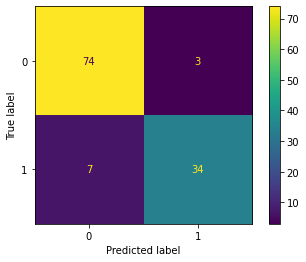

In [ ]:
import xgboost as xgb2
xgb2 = xgb3.XGBClassifier()
y_train_fin = y_train_fin.values.ravel()

xgb3.fit(X_train_fin,y_train_fin)

y_pred = xgb3.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(xgb3, X_test, y_test)
plt.show()  

              precision    recall  f1-score   support

           0       0.89      0.95      0.92        77
           1       0.89      0.78      0.83        41

    accuracy                           0.89       118
   macro avg       0.89      0.86      0.87       118
weighted avg       0.89      0.89      0.89       118



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


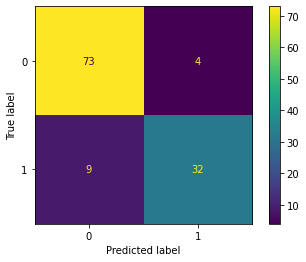

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=300, n_jobs=-1)
rf.fit(X_train_fin,y_train_fin)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(rf, X_test, y_test)
plt.show()

# Checking distributions of synthetic data(temporily not used)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:


df0 = df[df.LUNG_CANCER == 0]
#df1 = df[df.label == 1]
df1 = df[df.LUNG_CANCER == 1]
"""
mc = MinMaxScaler(feature_range=(0, 1))
standard_scaler0 = mc.fit(df0)
df0 = standard_scaler0.transform(df0)
#x_scaled = pd.DataFrame(df0)

standard_scaler1 = mc.fit(df1)
df1 = standard_scaler1.transform(df1)
"""
print(df0[0:5])
print(df1[0:5])


    AGE  SMOKING  YELLOW_FINGERS  ANXIETY  PEER_PRESSURE  CHRONIC DISEASE  \
2    59        1               1        1              2                1   
3    63        2               2        2              1                1   
4    63        1               2        1              1                1   
8    68        2               1        2              1                1   
12   60        2               1        1              1                1   

    FATIGUE   ALLERGY   WHEEZING  ALCOHOL CONSUMING  COUGHING  \
2          2         1         2                  1         2   
3          1         1         1                  2         1   
4          1         1         2                  1         2   
8          2         1         1                  1         1   
12         2         1         1                  1         1   

    SHORTNESS OF BREATH  SWALLOWING DIFFICULTY  CHEST PAIN  LUNG_CANCER  \
2                     2                      1           2            0

<b> For class 0

In [ ]:
print('FOR CLASS 0')
fig, axes = plt.subplots(16, 1, figsize=(10, 50))  # must change plot number

for n, col in enumerate(df.columns.to_list()[:-1]):
    ax1 = plt.subplot(16,1, n+1)  # must change plot number
    sns.distplot(x = df_generated_0[col], color = 'red', label = 'Generated')
    sns.distplot(x = df0[col], color = 'blue', label = 'real')
    plt.legend(fontsize = 12)  # 30
    plt.xlabel(col, fontsize = 12)  #30 
    plt.title(col, fontsize = 12)   #30
    plt.ylabel(' ')
plt.subplots_adjust(wspace=0.5,hspace=0.5)

<b> For class 1

In [ ]:
print('FOR CLASS 1')
fig, axes = plt.subplots(16, 1, figsize=(10, 50)) #must change font size 

for n, col in enumerate(df.columns.to_list()[:-1]):
    ax1 = plt.subplot(16,1, n+1)
    sns.distplot(x = df_generated_1[col], color = 'red', label = 'Generated')
    sns.distplot(x = df1[col], color = 'blue', label = 'real')
    plt.legend(fontsize = 12) # #30
    plt.xlabel(col, fontsize = 12)
    plt.title(col, fontsize = 12)
    plt.ylabel(' ')
plt.subplots_adjust(wspace=0.5,hspace=0.5)

Asssessment